# ICool Input File Parser
In the `icool` submodule there exists pydantic classes and tools for parsing the input files from the ICOOL muon cooling code. Use these tools for input file translation into other tools or analysis or lattices.

Note: this is a work in progress tool that does not implement all commands or elements. If you are interested in further features, feel free to contact me by creating an issue on Github. I am also happy to accept pull requests with additional objects.

In [1]:
from electronsandstuff.icool import ICoolInput, Cell, UnresolvedSubstitutionsError
import logging

logging.basicConfig(level=logging.INFO)

## Input File Loading
All data from the input files are loaded into the main class `ICoolInput`. This is done through the twin class methods `from_file` and `from_str` which will construct the input object from a file or string respectively. We demonstrate their use on an example shipped with the ICOOL code (adib.f01).

In [2]:
# Load the input object from a file
inp = ICoolInput.from_file("data/adib.f01")

# Examine the loaded cooling section commands
inp.cooling_section.commands

[RefP(name='REFP', refpar=2, phmodref=PhModRef3(name='PHMODREF3', pz0=SubKey(key='pref'), t0=0.0)),
 Ref2(name='REF2', refpar=2, phmodref=PhModRef3(name='PHMODREF3', pz0=0.1465, t0=0.0)),
 Repeat(name='REPEAT', n_repeat=4, commands=[SRegion(name='SREGION', slen=25.0, zstep=0.01, subregions=[RSubRegion(rlow=0.0, rhigh=1.0, field=FieldSol(name='SOL'), mtag='VAC', geometry=GeometryCBlock(name='CBLOCK'))])]),
 Cell(name='CELL', n_cells=1, cell_flip=False, field=FieldSol(name='SOL'), commands=[SRegion(name='SREGION', slen=1.0, zstep=0.01, subregions=[RSubRegion(rlow=0.0, rhigh=1.0, field=FieldAccel10(name='ACCEL10', phase=0.0, n_wavelen=15.0, reset=1.0, total_len=60.0, g0=0.0, g1=0.0, g2=4.8, phase_model=0), mtag='VAC', geometry=GeometryCBlock(name='CBLOCK'))])]),
 Cell(name='CELL', n_cells=59, cell_flip=False, field=FieldSol(name='SOL'), commands=[SRegion(name='SREGION', slen=1.0, zstep=0.01, subregions=[RSubRegion(rlow=0.0, rhigh=1.0, field=FieldAccel10(name='ACCEL10', phase=0.0, n_wavele

In [3]:
# Get parameters from one of the accelerating cavities
inp.cooling_section.commands[3].commands[0].subregions[0].field

FieldAccel10(name='ACCEL10', phase=0.0, n_wavelen=15.0, reset=1.0, total_len=60.0, g0=0.0, g1=0.0, g2=4.8, phase_model=0)

## Substitutions
The tool automatically handles substitutions. They are held onto and can the replacements can be performed using methods in the input object.

In [4]:
# Check if parameters have substitutions in their place
inp.has_substitutions

True

In [5]:
# Can also assert which will raise an exception
try:
    inp.assert_no_substitutions()
except UnresolvedSubstitutionsError as e:
    print(e)

Unresolved substitution 'pref' found in field 'ICoolInput.cooling_section.commands[0].phmodref.pz0'


In [6]:
# Perform the subsitution
inp_sub = inp.perform_substitutions()
inp_sub.assert_no_substitutions()

## Analysis
Some analysis features are included such as calculating the length of sections including repeated elements and all substitutions.

In [7]:
# Get the total length
print(f"Total length: {inp.get_length()} m")

# Get the length of each cooling cell
cell_idx = 0
for cmd in inp.cooling_section.commands:
    if isinstance(cmd, Cell):
        cell = cmd.model_copy()
        cell.n_cells = 1
        print(f"Cell {cell_idx+1} unit length: {cell.get_length():.2f} m")
        cell_idx += 1

Total length: 160.0 m
Cell 1 unit length: 1.00 m
Cell 2 unit length: 1.00 m


## Plotting

Some limited plotting of the layout is included. We plot the file here which consists of a drift (White) followed by some accelerating cavities (Maroon). The repeated section is shown in green and the cells in blue.

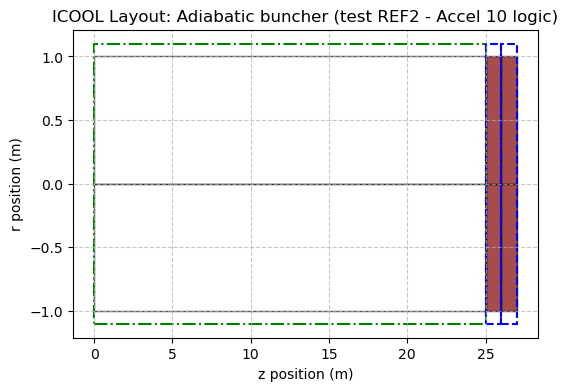

In [8]:
# Plot the layout
fig, ax = inp.plot_layout()